
# ML-1: Collaborative filtering
## Project: Building a Restaurant Recommendation System

## Baseline Model


**ML-1 Cohort 1** <br>

Name of people who have worked on this project: 

Nehal Sharma 11675

Keerthi Jayaram 11688

Manila Devaraj 11699

Gurushankar K. 500



## Table of Contents 

* Loading Data
* Setting up the model
  * Train-test Split
* Training the model
* Fitting the model
  * Making Rating Prdictions
  * Making Recommendation to users
  * Business Biases
  * User Biases
* Results
* Limitations of the base model
  

## Overview

### The baseline model

<img src="https://nick-morgan.github.io/Python-Recommendation-Engine-Yelp/images/projectgoal.png" width=500/> 

***Image credits:https://nick-morgan.github.io/***



**1) We import the data obtained from the analysis done in our EDA notebook (refer : EDA_NOTEBOOK_NAME_HERE.ipynb, and perform train-test split on the data.**

**2) The data is split into Training , Validation and Test sets in the proportion of 60% , 20% and 20% respectively.**

**3) We then set our hypeparameters, the size of the latent factors or the embeddings,  and the amount of regularization for the model. We use the Keras functional API as we have two beginning points that need merging :**
    
    
   * ***User_id input layer***

   * ***Business_id input layer***
    
**4) Our data consists of 3 columns, the user_id, business_id and the third being the stars(rating). We pass user_id on left and business_id on right as the inputs and obtain output of the sigmoid.
   Our model is then compiled with Stochastic Gradient Descent (SGD) and we vary the learning rates (lr) to get best fit.**
 

**5) For the predictions, we pass an array of user_ids business_ids in the** ***model.predict()*** **function.**

**6) Similar to the predictions, we then create a Model instance for the user biases and business(restaurant) biases.**


### **Importing the neccesary libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

## Loading Data

In [ ]:
df = pd.read_csv("processed_data/reviews_contig.csv", index=False)

In [186]:
df.head()

,user_id,business_id,stars
0,0,0,4
1,1,1,4
2,2,2,5
3,3,3,3
4,4,4,1


In [185]:
business_df = pd.read_csv("processed_data/businesses_contig.csv")

**Indexing the business_df dataframe using the unique business "id" that we generated in the previous segment.**

In [ ]:
business_df = business_df.drop('business_id', axis=1).set_index('id')
business_df.head()

In [187]:
business_df.head()

,name,categories
0,Philthy Phillys,"Restaurants, Cheesesteaks, Poutineries"
1,Mi Mi Restaurant,"Vietnamese, Restaurants"
2,The Market by Longo's,"Food, Grocery"
3,GIG@bites Internet Cafe,"Home Services, Shopping, IT Services & Compute..."
4,Tim Hortons,"Cafes, Donuts, Food, Coffee & Tea, Restaurants"


**Finding out the total number of unique Users and Businesses in our Dataset**

In [59]:
nusers = df.user_id.nunique()
nbusinesses = df.business_id.nunique()
nusers, nbusinesses

(18328, 939)

In [60]:
print(f"The total number of unique Users :{nusers}")
print(f"The total number of unique Businesses :{nbusinesses}")

(18328, 939)

## Setting up the Model

### Train-test split

**We divided our data into Training , Validation and Testing datasets in the following ratio :**

| Data Type | Percentage|
| --- | --- |
| Training | 60% |
| Validation | 20% |
| Test | 20% |

In [61]:
from sklearn.model_selection import train_test_split
np.random.seed=2017

**Step-1) Dividing Data into Train and Test sets**

In [62]:
train_indices, test_indices = train_test_split(range(df.shape[0]), test_size=0.20)
trdf1 = df.iloc[train_indices]
testdf = df.iloc[test_indices]

print(f" The size of our test data :{testdf.shape}")

(6157, 3)

**Step-2) We further divide Train Data into Train and Validation sets**

In [63]:
train_indices, val_indices = train_test_split(range(trdf1.shape[0]), test_size=0.25)# 0.25 x 0.8 = 0.2
trdf = trdf1.iloc[train_indices]
valdf = trdf1.iloc[val_indices]

print(f" The size of our Training data :{trdf.shape}")
print(f" The size of our Validation data :{valdf.shape}")

((18469, 3), (6157, 3))

In [65]:
trdf.head()

,user_id,business_id,stars
30619,4807,826,3
89,89,84,4
9678,7276,104,4
7052,5552,160,4
10439,7750,208,1


In [66]:
valdf.head()

,user_id,business_id,stars
139,139,115,3
19870,13007,89,3
25562,10149,208,4
22838,14527,363,3
12664,3112,133,4


In [67]:
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

2.4.1


In [68]:
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

**We then set our hypeparameters, the size of the latent factors or the embeddings,  and the amount of regularization.**

In [69]:
L = 50

In [70]:
REG=5e-4

**Function to return us a bias layer:**

In [71]:
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

**Function to set us up an embedding layer:**

In [72]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

*This function will return input layers which we will use as placeholders for our inputs, which are the **user_id** and **business_id** that are used as indexes into the embedding to get the latent factors for a particular user or a business.*

**Definining Embeddings and Biases**

In [73]:
user_input, uLmat = embedding_input('user_input', nusers, L, REG)
business_input, mLmat = embedding_input('business_input', nbusinesses, L, REG)

User input is a placeholder for user_id and business_id

In [74]:
user_input.shape, business_input.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [75]:
uLmat.shape, mLmat.shape

(TensorShape([None, 1, 50]), TensorShape([None, 1, 50]))

In [76]:
user_bias = create_bias('user_bias', user_input, nusers, REG)
business_bias = create_bias('business_bias', business_input, nbusinesses, REG)

In [77]:
user_bias.shape, business_bias.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

**These embeddings are matrix multiplied together (dot producted together) to get the residual matrix, which is then flattened.**

In [78]:
residual = Dot(axes=2, name="residual")([uLmat, mLmat])

In [79]:
residual.shape

TensorShape([None, 1, 1])

In [80]:
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

**The flattened residual and the biases are added into the linear regression**

In [81]:
regression = Add(name="regression")([user_bias, business_bias, residflat])

In [82]:
regression.shape

TensorShape([None, 1])

***We then want to limit our ratings between between 0 and 5.5.***

***This is accomplished by using a sigmoid after the regression part, by scaling the sigmoid to the required range(0 and 5.5)***

***This is done to avoid letting our regression function go outside of the rating scale.(i.e. 0 to 5)***

In [83]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import backend as K

In [84]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [85]:
cs = sigmoid_maker(0, 5.5)

In [86]:
output = Activation(cs, name="Sigmoid_Range")(regression)

**Our model is then set up with the userids and businessids as input, and the output of the sigmoid as output.**

**It is compiled with SGD and a learning rate of 0.001.**

In [201]:
model = Model([user_input, business_input], output)
model.compile(optimizer = 'sgd', loss='mse')

In [202]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
business_input (InputLayer)     [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_factor (Embedding)         (None, 1, 50)        916400      user_input[0][0]                 
__________________________________________________________________________________________________
business_factor (Embedding)     (None, 1, 50)        46950       business_input[0][0]             
____________________________________________________________________________________________

**We use the Keras functional API as we have two beginning points that need
merging :**
    
    
   * ***User_id input layer***

   * ***Business_id input layer***

In [203]:
import pydot

In [90]:
from tensorflow.keras.utils import model_to_dot

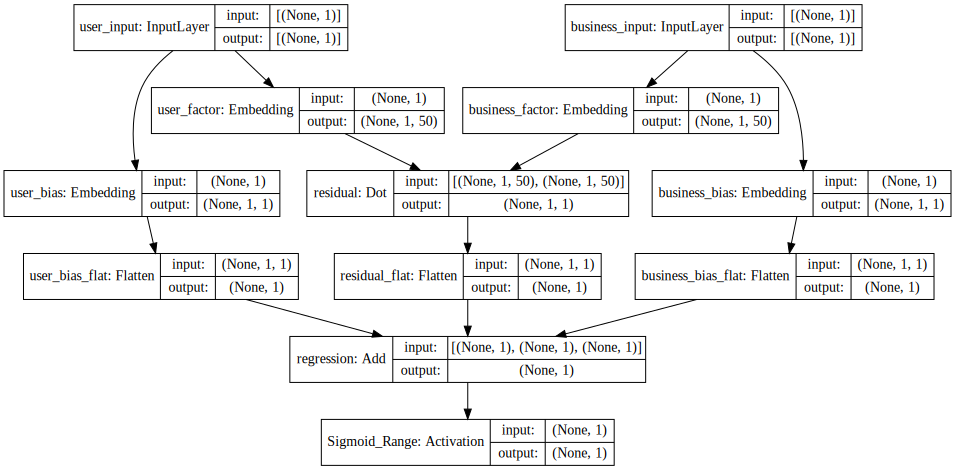

In [204]:
from IPython.display import SVG
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

## Training the model

**We train our model on Training data and evaluate the best fit of the hyperparameters by testing on validation dataset.**

**First, we start slow with a learning rate of 0.001, then speed up to 0.01 and then slow back down so that we dont overshoot into having our validation loss climb back up to avoid overfitting.**

In [205]:
model.optimizer.lr=0.001
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=128, epochs=1, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

145/145 [==============================] - 5s 17ms/step - loss: 1.0195 - val_loss: 1.3476


In [206]:
model.optimizer.lr=0.01
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=128, epochs=1, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

145/145 [==============================] - 2s 13ms/step - loss: 1.0384 - val_loss: 1.3470


In [207]:
model.optimizer.lr=0.001
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=128, epochs=4, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

Epoch 1/4
145/145 [==============================] - 2s 13ms/step - loss: 1.0372 - val_loss: 1.3469
Epoch 2/4
145/145 [==============================] - 2s 13ms/step - loss: 1.0371 - val_loss: 1.3469
Epoch 3/4
145/145 [==============================] - 2s 13ms/step - loss: 1.0370 - val_loss: 1.3468
Epoch 4/4
145/145 [==============================] - 2s 13ms/step - loss: 1.0368 - val_loss: 1.3468


In [208]:
model.optimizer.lr=0.001
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=128, epochs=2, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

Epoch 1/2
145/145 [==============================] - 2s 14ms/step - loss: 1.0367 - val_loss: 1.3467
Epoch 2/2
145/145 [==============================] - 2s 13ms/step - loss: 1.0366 - val_loss: 1.3466


# Fitting Model with Train+Val Data and Testing on Test Data

**After finding the best fit and hyperparameters , we again fit the model, this time on both Training + Test data and evaluate it using the Test data.**

In [209]:
model.optimizer.lr=0.001
model.fit([trdf1.user_id, trdf1.business_id], trdf1.stars, batch_size=128, epochs=2, 
          validation_data=([testdf.user_id, testdf.business_id], testdf.stars))

Epoch 1/2
193/193 [==============================] - 2s 13ms/step - loss: 1.1140 - val_loss: 1.5021
Epoch 2/2
193/193 [==============================] - 2s 12ms/step - loss: 1.1138 - val_loss: 1.5020


In [97]:
model.save_weights("processed_data/cf.h5")

## Making Rating Predictions

**For making Predictions,we need to provide the userids and businessids to our model in an array.**

In [103]:
df[(df.user_id==3553) & (df.business_id==673)]

,user_id,business_id,stars
30768,3553,673,3


In [104]:
model.predict([np.array([3553]), np.array([673])])

array([[3.3512654]], dtype=float32)

**Our model did quite a decent job of predicting the value of the restaurant in this case** -

| Actual rating | Prediction|
| --- | --- |
| 3 | 3.35 |


**However, if we move towards the extreme rating values i.e. close to 1 or 5, our model starts to perform poorly.**

In [189]:
df[(df.user_id==18318) & (df.business_id==17)]

,user_id,business_id,stars
30767,18318,17,5


In [190]:
model.predict([np.array([18318]), np.array([17])])

array([[3.8993392]], dtype=float32)

In [192]:
df[(df.user_id==18308) & (df.business_id==640)]

,user_id,business_id,stars
30747,18308,640,1


In [193]:
model.predict([np.array([18308]), np.array([640])])

array([[2.227119]], dtype=float32)

**Prediction when the ratings are extreme values** - 

| Actual rating | Prediction|
| --- | --- |
| 5 | 3.89 |
| 1 | 2.22 |

## Making Recomendations to Users

In [211]:
#Total number of unique businesses

len(business_names)

939

#### Steps innvolved :
1) **Get the dataframe of all the restaurants currently rated by the user.**

2) **Getting the list of all the restaurants that are not rated by the user.**

3) **Predicting the rating of all the restaurants that are not rated by the user**

4) **Choosing the top 5 highest rated predictions and recommending them to the users.**

#### The top 5 Recomendations for User_id = 94

In [180]:

dfuser94 = df[(df.user_id==94)].sort_values('stars', ascending=False)
dfuser94['business'] = dfuser94.business_id.apply(lambda x: business_names[x])
dfuser94.head()

,user_id,business_id,stars,business
94,94,87,5,Riddle Room


In [181]:
businesses_not_been = list(set(df.business_id) - set(dfuser94.business_id))
dfuser94['predictions'] = model.predict([dfuser94.user_id, dfuser94.business_id]).ravel()
predictions = model.predict([np.array([3]*len(businesses_not_been)), np.array(businesses_not_been)]).ravel()


In [182]:
dfuser94preds = pd.DataFrame(dict(
    business_id = businesses_not_been,
    predictions = predictions
))
dfuser94preds['business'] = dfuser94preds.business_id.apply(lambda x: business_names[x])
dfuser94preds['user_id'] = 94
dfuser94preds.sort_values('predictions', ascending=False).head(5)

,business_id,predictions,business,user_id
182,183,4.032211,Plentea,94
84,84,4.016637,Hodo Kwaja,94
74,74,4.016085,Nuit Social,94
393,394,3.995870,Sasaki Fine Pastry,94
56,56,3.986487,Sansotei,94


#### Making Top 5 Recomendations for User_id = 71

In [179]:
dfuser71 = df[(df.user_id==71)].sort_values('stars', ascending=False)
dfuser71['business'] = dfuser71.business_id.apply(lambda x: business_names[x])
dfuser71.head()

businesses_not_been = list(set(df.business_id) - set(dfuser71.business_id))

dfuser71['predictions'] = model.predict([dfuser71.user_id, dfuser71.business_id]).ravel()
predictions = model.predict([np.array([3]*len(businesses_not_been)), np.array(businesses_not_been)]).ravel()


dfuser71preds = pd.DataFrame(dict(
    business_id = businesses_not_been,
    predictions = predictions
))

dfuser71preds['business'] = dfuser71preds.business_id.apply(lambda x: business_names[x])
dfuser71preds['user_id'] = 71
dfuser71preds.sort_values('predictions', ascending=False).head(5)

,business_id,predictions,business,user_id
68,87,4.078497,Riddle Room,71
148,183,4.032211,Plentea,71
58,74,4.016085,Nuit Social,71
43,56,3.986487,Sansotei,71
51,65,3.977667,Completo,71


## Interpretations


In [212]:
g=df.groupby('business_id')['stars'].count()
places=g.sort_values(ascending=False)[:2000]
places = np.array(places.index)

We take the 2000 most active users

In [213]:
g2=df.groupby('user_id')['stars'].count()
people=g2.sort_values(ascending=False)[:2000]
people = np.array(people.index)

We construct a new model with business_ids as input and bias as output. It uses the embedding numbers to give us the bias for any business. Given this model we use it to predict the bias of popular places..

In [217]:
get_business_bias = Model(business_input, business_bias)
bb_places = get_business_bias.predict(places)
places_ratings = [(b[0], business_names[i]) for i,b in zip(places,mb_places)]

We do the same for users

In [218]:
get_user_bias = Model(user_input, user_bias)
ub_people = get_user_bias.predict(people)
people_ratings = [(b[0], i) for i,b in zip(people,ub_people)]

### Business Biases

**This describes the average sentiment on the restaurants from all users**

**Here are the top 15 predictions of higly (+ive) rated restaurants in Ontario (ON) :**

In [219]:
from operator import itemgetter
sorted(places_ratings, key=itemgetter(0), reverse=True)[:15]

[(1.0298043, 'Riddle Room'),
 (0.9860453, 'Plentea'),
 (0.9712213, 'Hodo Kwaja'),
 (0.9712062, 'Nuit Social'),
 (0.95154, 'Sasaki Fine Pastry'),
 (0.9433582, 'Sansotei'),
 (0.9352464, 'Completo'),
 (0.9348159, 'Aloette'),
 (0.9139983, 'Mamajoun Armenian Pizzeria'),
 (0.90274, "Jimmy's Coffee"),
 (0.8935958, 'Jim Chai Kee'),
 (0.89025503, 'Sushi House'),
 (0.8901037, 'Our Spot'),
 (0.88843846, 'Veghed'),
 (0.8742392, 'Mon K Patisserie')]

**Similarly, the predictions of the most poorly (-ive bias) rated restaurants in Ontario (ON) :**

In [221]:
sorted(places_ratings, key=itemgetter(0))[:15]

[(-0.590328, "McDonald's"),
 (-0.58882767, 'Paramount Lebanese Kitchen'),
 (-0.527985, 'Swiss Chalet Rotisserie & Grill'),
 (-0.47805712, 'Basil Express Restaurant'),
 (-0.4691102, 'Dairy Queen'),
 (-0.45552737, "McDonald's"),
 (-0.4388413, "McDonald's"),
 (-0.40785533, 'Pita Land'),
 (-0.38117245, 'Tzatziki'),
 (-0.37400988, "Gabby's Kingston Road"),
 (-0.3683726, 'Pizza Pizza'),
 (-0.3622325, 'Wal-Mart'),
 (-0.32666352, 'Subway'),
 (-0.3226322, 'Swiss Chalet Rotisserie & Grill'),
 (-0.3161704, 'Washoku')]

***Note: here we see McDonald's at multiple places, because they are from different outlets spread over the province.***

**Mean Restaurant Bias**

In [223]:
np.mean([e[0] for e in places_ratings])

0.25230792

### User Biases


**Here are the top 15 predictions of users that very easily give high ratings to the restaurants :**

In [224]:
sorted(people_ratings, key=itemgetter(0), reverse=True)[:15]

[(0.52569383, 840),
 (0.50802195, 2404),
 (0.47729522, 3625),
 (0.45544356, 3205),
 (0.44740987, 917),
 (0.44343752, 7378),
 (0.44234553, 1237),
 (0.4411573, 566),
 (0.43496272, 4096),
 (0.42024016, 484),
 (0.41985217, 1900),
 (0.41726762, 1444),
 (0.416955, 2681),
 (0.41572645, 2906),
 (0.40784916, 2501)]

**On the contrary, here are the top 15 most hard to please users**

In [225]:
sorted(people_ratings, key=itemgetter(0))[:15]

[(-0.465115, 13967),
 (-0.41462725, 562),
 (-0.39329407, 2491),
 (-0.38856244, 748),
 (-0.38057527, 1195),
 (-0.36665863, 4289),
 (-0.3628298, 1963),
 (-0.3548793, 5242),
 (-0.35277542, 2067),
 (-0.35185823, 2585),
 (-0.3422162, 34),
 (-0.33527854, 6911),
 (-0.32746944, 4976),
 (-0.32588536, 4008),
 (-0.32237458, 7982)]

**Mean User Bias**

In [226]:
np.mean([e[0] for e in people_ratings])

0.11633664

**The overall mean of the stars(rating)**

In [228]:
np.mean(df.stars)

3.644121755514407

## Results

### A) Making rating predictions

- **We observed that the baseline model worked reasonably well, when predicting the restaurant ratings for a user, in the central range of 2-4 star ratings.**

- **The base model did a pretty poor job at predicting the restaurant ratings for a user, in the case of extreme user ratings i.e.** ***ratings < 2 and ratings > 5***

/home/nehal/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/nehal/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/nehal/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0, 0.5, 'prediction')

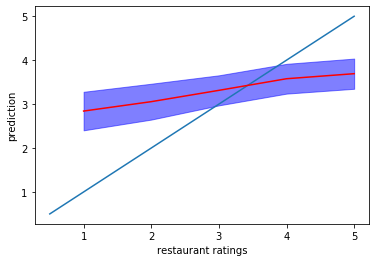

In [198]:
dfpreds = df[['business_id', 'stars', 'user_id']].copy()
dfpreds['predictions'] = model.predict([dfpreds.user_id, dfpreds.business_id]).ravel()

preds_stats=dfpreds.groupby('stars')['predictions'].describe().reset_index()

plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats.stars, preds_stats['mean'], color="red")
plt.fill_between(preds_stats.stars, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="blue", alpha=0.5)
plt.xlabel("restaurant ratings")
plt.ylabel("prediction")


### B) Making Recomendations to Users

- **We made user recommendations , based on the predicted ratings of the restaurants that the user had not visited. These predictions were then sorted w.r.t. to their ratings and the top 5 highest predicted restaurants were recommended to the user.**

- **Our model performed well for the users that had rated a substantial number of restaurants, but for the users that did not rate many restaurants (eg- number_of_rated_restaurants < 5), the model's recommendations became redundant and top rated restaurants' recommendations for these cohort of users became quite similar.**

## Limitations of the base model

* **While making rating predictions, the baseline model performs poorly for extreme range ratings (i.e. for ratings<2 and ratings >4)**


*  **For the users that have reviewed lesser number of restaurants (<5), then the base model's recommendation to those user sets becomes reduandant.**



**We try and adress some of the above mentioned limitations in our Improvement Model.**


***refer : shortreviewbased_recommend_with content.ipynb***

***Notebook References :***
* ***https://nick-morgan.github.io/Python-Recommendation-Engine-Yelp/***
* ***(Collaborative Filtering - Setup, Training, and Interpretation.pdf) - By Prof Rahul Dave***
* ***https://sites.northwestern.edu/msia/2019/04/24/personalized-restaurant-recommender-system-using-hybrid-approach/***